<a href="https://colab.research.google.com/github/mbauergit/PREPARE-Alzheimers-Challenge/blob/main/PREPARE_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import re
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
from scipy.spatial.distance import cdist
from sklearn.metrics import root_mean_squared_error

from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

!pip install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

!pip install catboost
from catboost import CatBoostRegressor

!pip install gower
import gower
drive.mount('/content/drive')

!pip install lightgbm
from lightgbm import LGBMRegressor
import lightgbm as lgb
from scipy.optimize import minimize
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### EDA ###

In [ ]:
train_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_features.csv')
train_labels_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_labels.csv')
test_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/test_features.csv')

In [ ]:
train_features_orig.describe()
train_labels_orig.describe()

,year,composite_score
count,4343.000000,4343.000000
mean,2019.162560,157.016809
std,2.410882,60.909546
min,2016.000000,4.000000
25%,2016.000000,114.000000
50%,2021.000000,157.000000
75%,2021.000000,200.000000
max,2021.000000,334.000000


#### Label EDA ####

<Axes: xlabel='composite_score', ylabel='Count'>

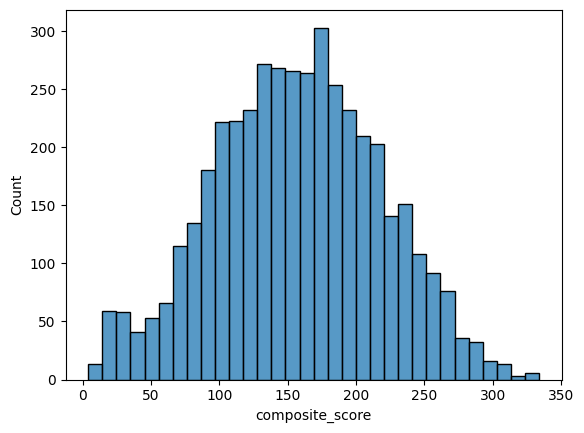

In [ ]:
sns.histplot(train_labels_orig['composite_score'])

              2016         2021   score_diff
count  1067.000000  1067.000000  1067.000000
mean    172.952202   165.306467    -7.645736
std      60.642623    56.549409    31.355495
min      10.000000    17.000000  -163.000000
25%     133.500000   126.000000   -26.000000
50%     175.000000   164.000000    -8.000000
75%     217.000000   202.500000    11.000000
max     334.000000   331.000000   142.000000


<Axes: xlabel='score_diff', ylabel='Count'>

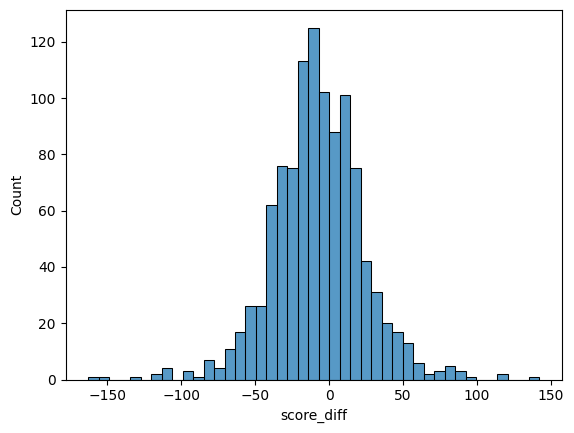

In [ ]:
# Explore the difference between 2016 and 2021 scores for same individuals
def score_diff(group):
    return group['2021'] - group['2016']

label_uid_counts = train_labels_orig['uid'].value_counts()
labels_above_100 = train_labels_orig[train_labels_orig['composite_score'] > 0]
two_scores = labels_above_100[labels_above_100['uid'].isin(label_uid_counts[label_uid_counts == 2].index)]
two_scores_pivot_df = two_scores.pivot(index='uid', columns='year', values='composite_score')
two_scores_pivot_df.columns = ['2016', '2021']
two_scores_pivot_df['score_diff'] = two_scores_pivot_df.apply(score_diff, axis=1)
two_scores_pivot_df.head(10)
print(two_scores_pivot_df.describe())

sns.histplot(two_scores_pivot_df['score_diff'])

#### Make Dataframe all numerical values ####

In [ ]:
# Extract numerical values from dataframe
def parse_class_num(value):
    try:
        value_str = str(value).split('.')[0]
        return int(value_str)
    except (ValueError, AttributeError):
        return None

columns_to_convert = ['age_03', 'age_12', 'urban_03', 'urban_12', 'married_03', 'married_12', 'edu_gru_03', 'edu_gru_12',\
                      'n_living_child_03', 'n_living_child_12', 'glob_hlth_03', 'glob_hlth_12', 'bmi_03', 'bmi_12', 'decis_famil_03', 'decis_famil_12',\
                      'decis_personal_03', 'decis_personal_12', 'employment_03', 'employment_12', 'memory_12', 'ragender', 'rrelgimp_03', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12',\
                      'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12']

columns_to_remove = ['rameduc_m', 'rafeduc_m', 'sgender_03', 'rjob_hrswk_03', 'rjlocc_m_03', 'rjob_end_03', 'rjobend_reason_03', 'rearnings_03', 'searnings_03', 'hinc_business_03',\
                     'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03', 'j11_12', 'a33b_12', 'a22_12', 'a16a_12',\
                     'sgender_12', 'rjob_hrswk_12', 'rjlocc_m_12', 'rjob_end_12', 'rjobend_reason_12', 'rearnings_12', 'searnings_12', 'hinc_business_12',\
                     'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12', 'a34_12']


train_features = train_features_orig.copy()
train_features[columns_to_convert] = train_features[columns_to_convert].applymap(parse_class_num)
train_features = train_features.drop(columns=columns_to_remove)
train_features.set_index('uid', inplace=True)
joined_df = train_labels_orig.join(train_features, on='uid').set_index(['uid', 'year'])
joined_df.head()

composite_score  age_03  urban_03  married_03  n_mar_03  \
uid  year                                                            
aace 2021              175     NaN       NaN         NaN       NaN   
aanz 2021              206     NaN       NaN         NaN       NaN   
aape 2016              161     NaN       NaN         NaN       NaN   
     2021              144     NaN       NaN         NaN       NaN   
aard 2021              104     1.0       1.0         3.0       1.0   

           edu_gru_03  n_living_child_03  migration_03  glob_hlth_03  \
uid  year                                                              
aace 2021         NaN                NaN           NaN           NaN   
aanz 2021         NaN                NaN           NaN           NaN   
aape 2016         NaN                NaN           NaN           NaN   
     2021         NaN                NaN           NaN           NaN   
aard 2021         3.0                1.0           0.0           4.0   

           adl_dress_03  ...  memory_12  ragender  hincome_03  rrelgimp_03  \
uid  year                ...                                                 
aace 2021           NaN  ...        2.0         1         NaN          NaN   
aanz 2021           NaN  ...        4.0         1         NaN          NaN   
aape 2016           NaN  ...        4.0         2         NaN          NaN   
     2021           NaN  ...        4.0         2         NaN          NaN   
aard 2021           0.0  ...        3.0         2         0.0          1.0   

           hincome_12  rrelgimp_12  rrfcntx_m_12  rsocact_m_12  rrelgwk_12  \
uid  year                                                                    
aace 2021    140000.0          2.0           9.0           9.0         0.0   
aanz 2021     70000.0          1.0           9.0           1.0         0.0   
aape 2016         0.0          2.0           6.0           2.0         0.0   
     2021         0.0          2.0           6.0           2.0         0.0   
aard 2021         0.0          1.0           4.0           9.0         1.0   

           a21_12  
uid  year          
aace 2021     NaN  
aanz 2021     NaN  
aape 2016     NaN  
     2021     NaN  
aard 2021     NaN  

[5 rows x 151 columns]

#### Correlation Matrix ####

In [ ]:
# Build correlation matrix for all variables
joined_df = train_labels_orig.join(train_features, on='uid').set_index(['uid', 'year'])
display(joined_df.head())
correlation_matrix = train_X.corr()
# display(correlation_matrix)
# joined_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/joined_df.csv')
# correlation_matrix.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/correlation_matrix.csv')

# Flatten the correlation matrix and filter high correlations
corr_flat = correlation_matrix.corr().unstack().reset_index()
corr_flat.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = corr_flat[(corr_flat['Correlation'].abs() > 0.5) & (corr_flat['Variable 1'] != corr_flat['Variable 2'])]
high_corr = high_corr.sort_values(by='Correlation', ascending=False)
high_corr = high_corr.drop_duplicates(subset=['Correlation'])
# high_corr.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/high_corr.csv')
# Display high correlations
print(high_corr)

composite_score  age_03  urban_03  married_03  n_mar_03  \
uid  year                                                            
aace 2021              175     NaN       NaN         NaN       NaN   
aanz 2021              206     NaN       NaN         NaN       NaN   
aape 2016              161     NaN       NaN         NaN       NaN   
     2021              144     NaN       NaN         NaN       NaN   
aard 2021              104     NaN       NaN         NaN       NaN   

           edu_gru_03  n_living_child_03  migration_03  glob_hlth_03  \
uid  year                                                              
aace 2021         NaN                NaN           NaN           NaN   
aanz 2021         NaN                NaN           NaN           NaN   
aape 2016         NaN                NaN           NaN           NaN   
     2021         NaN                NaN           NaN           NaN   
aard 2021         NaN                NaN           NaN           NaN   

           adl_dress_03  ...  rrelgimp_12  rrfcntx_m_12  rsocact_m_12  \
uid  year                ...                                            
aace 2021           NaN  ...          NaN           NaN           NaN   
aanz 2021           NaN  ...          NaN           NaN           NaN   
aape 2016           NaN  ...          NaN           NaN           NaN   
     2021           NaN  ...          NaN           NaN           NaN   
aard 2021           NaN  ...          NaN           NaN           NaN   

           rrelgwk_12  a16a_12  a21_12  a22_12  a33b_12  a34_12  j11_12  
uid  year                                                                
aace 2021         NaN      NaN     NaN     NaN      NaN     NaN     NaN  
aanz 2021         NaN      NaN     NaN     NaN      NaN     NaN     NaN  
aape 2016         NaN      NaN     NaN     NaN      NaN     NaN     NaN  
     2021         NaN      NaN     NaN     NaN      NaN     NaN     NaN  
aard 2021         NaN      NaN     NaN     NaN      NaN     NaN     NaN  

[5 rows x 184 columns]

          Variable 1        Variable 2  Correlation
265             hard            n_depr     0.905059
478           n_depr            lonely     0.891560
301         restless            n_depr     0.868991
479           n_depr             tired     0.857967
403            tired              hard     0.792309
295         restless              hard     0.787738
520         diabetes       n_illnesses     0.786256
133          edu_gru          reads_12     0.778971
262             hard            lonely     0.767971
299         restless             tired     0.733711
193        glob_hlth            n_depr     0.724670
368           lonely          restless     0.723936
371           lonely             tired     0.689095
187        glob_hlth              hard     0.687871
556        arthritis       n_illnesses     0.687214
134          edu_gru          games_12     0.680901
39             urban           edu_gru     0.668732
961         games_12          reads_12     0.643750
401         

#### Individual variables vs score ####

<Axes: xlabel='edu_gru_03', ylabel='composite_score'>

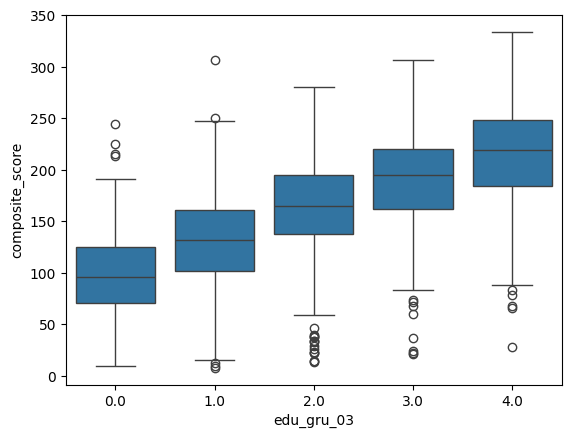

In [ ]:
# Compare education vs composite score
sns.boxplot(data=joined_df, x='edu_gru_03', y='composite_score')

<Axes: xlabel='age_03', ylabel='composite_score'>

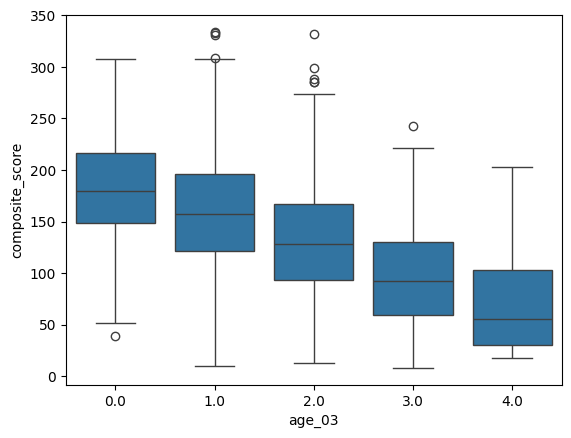

In [ ]:
sns.boxplot(data=joined_df, x='age_03', y='composite_score')

<Axes: xlabel='rrfcntx_m_12', ylabel='composite_score'>

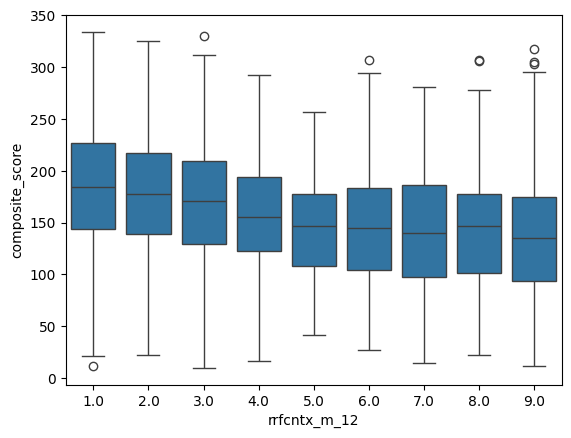

In [ ]:
sns.boxplot(data=joined_df, x='rrfcntx_m_12', y='composite_score')

<Axes: xlabel='rsocact_m_12', ylabel='composite_score'>

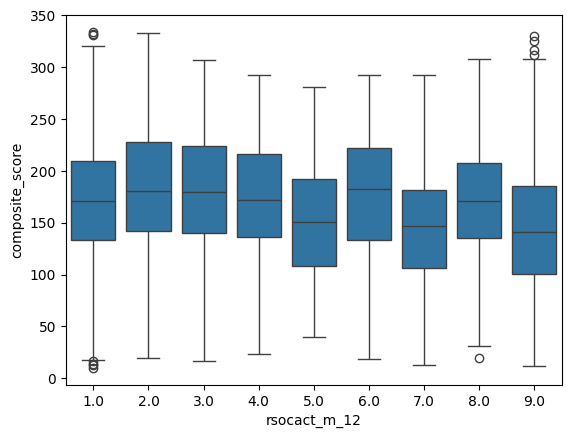

In [ ]:
sns.boxplot(data=joined_df, x='rsocact_m_12', y='composite_score')

<Axes: xlabel='hincome_12', ylabel='composite_score'>

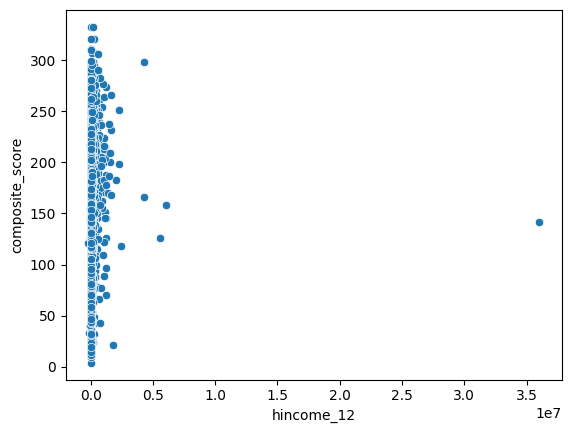

In [ ]:

sns.(data=joined_df, x='hincome_12', y='composite_score')

<Axes: xlabel='composite_score', ylabel='Count'>

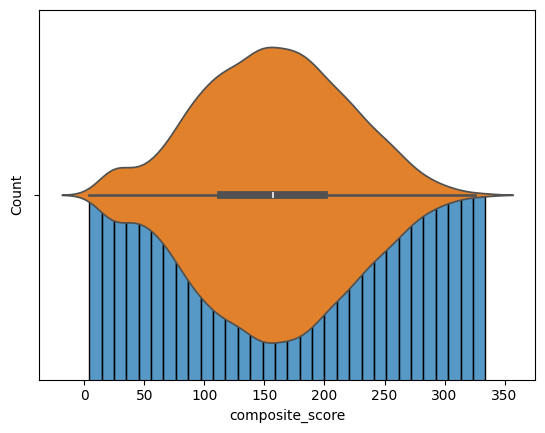

In [ ]:
# Composite Score exploration
sns.histplot(joined_df['composite_score'])

<Axes: xlabel='composite_score'>

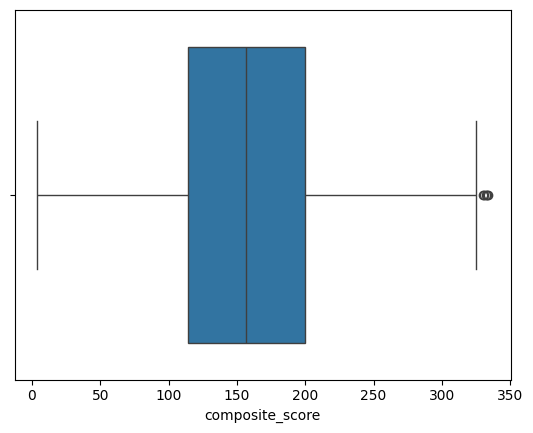

In [ ]:
sns.boxplot(data=joined_df, x='composite_score')

<Axes: xlabel='n_adl_12', ylabel='composite_score'>

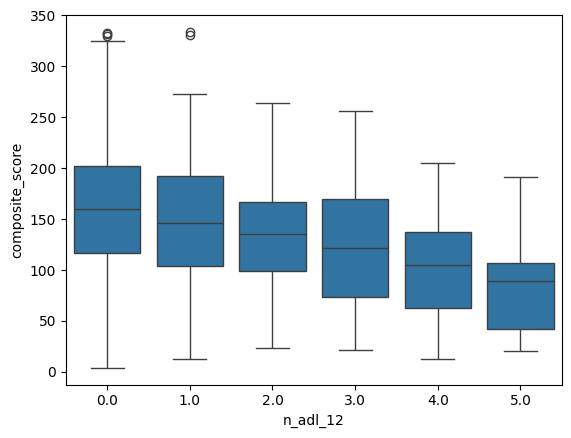

In [ ]:
sns.boxplot(data=joined_df, x='n_adl_12', y='composite_score')

0.3632318200703178


<Axes: xlabel='agexedu', ylabel='composite_score'>

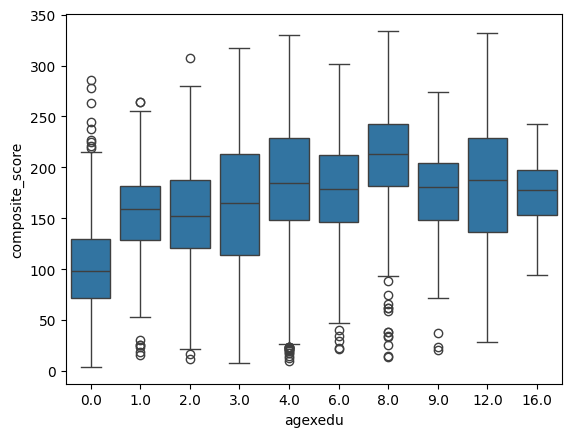

In [ ]:
feature_df['new_age'] = feature_df['age'] + (feature_df['years_passed'] / 10)
feature_df['agexedu'] = feature_df['age'] * feature_df['edu_gru']
correlation = feature_df['agexedu'].corr(feature_df['composite_score'])
sns.boxplot(data=feature_df, x='agexedu', y='composite_score')

In [ ]:
sns.boxplot(data=feature_df, x='age', y='composite_score')

#### Feature Engineering ####

In [ ]:
train_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_features.csv')
train_labels_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_labels.csv')
test_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/test_features.csv')

(3276, 184)
(4343, 3)
(819, 184)


In [ ]:
# Convert categories to numerical numbers
def parse_class_num(value):
    try:
        value_str = str(value).split('.')[0]
        return int(value_str)
    except (ValueError, AttributeError):
        return None

def convert_categorical_to_numerical(df):
    columns_to_convert = ['age_03', 'age_12', 'urban_03', 'urban_12', 'married_03', 'married_12', 'edu_gru_03', 'edu_gru_12',\
                        'n_living_child_03', 'n_living_child_12', 'glob_hlth_03', 'glob_hlth_12', 'bmi_03', 'bmi_12', 'decis_famil_03', 'decis_famil_12',\
                        'decis_personal_03', 'decis_personal_12', 'employment_03', 'employment_12', 'memory_12', 'ragender', 'rrelgimp_03', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12',\
                        'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12']

    columns_to_remove = ['rameduc_m', 'rafeduc_m', 'sgender_03', 'rjob_hrswk_03', 'rjlocc_m_03', 'rjob_end_03', 'rjobend_reason_03', 'rearnings_03', 'searnings_03', 'hinc_business_03',\
                        'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03', 'j11_12', 'a33b_12', 'a22_12', 'a16a_12',\
                        'sgender_12', 'rjob_hrswk_12', 'rjlocc_m_12', 'rjob_end_12', 'rjobend_reason_12', 'rearnings_12', 'searnings_12', 'hinc_business_12',\
                        'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12', 'a34_12']

    df[columns_to_convert] = df[columns_to_convert].applymap(parse_class_num)
    df = df.drop(columns=columns_to_remove)
    return df


train_features = convert_categorical_to_numerical(train_features_orig)
train_features.set_index('uid', inplace=True)
train_features.head()
train_features.shape[0]

3276

In [ ]:
# Calculate number of rows that have both age_03 and age_12
num_rows_with_both_ages = (train_features['age_03'].notna() & train_features['age_12'].notna()).sum()
print(f"Number of rows with both age_03 and age_12: {num_rows_with_both_ages}")

num_rows_only_2003 = (train_features['age_03'].notna() & train_features['age_12'].isna()).sum()
print(f"Number of rows with only age_03: {num_rows_only_2003}")

num_rows_only_2012 = (train_features['age_12'].notna() & train_features['age_03'].isna()).sum()
print(f"Number of rows with only age_12: {num_rows_only_2012}")

num_rows_with_no_ages = (train_features['age_03'].isna() & train_features['age_12'].isna()).sum()
print(f"Number of rows with no age information: {num_rows_with_no_ages}")

Number of rows with both age_03 and age_12: 2151
Number of rows with only age_03: 89
Number of rows with only age_12: 1035
Number of rows with no age information: 1


In [ ]:
# For those with both 2003 and 2012, calculate change in variables
both_years = ['age', 'urban', 'married', 'edu_gru', 'n_living_child', 'glob_hlth', 'adl_dress', 'adl_walk', 'adl_bath',
                'adl_eat', 'adl_bed', 'adl_toilet', 'n_adl', 'iadl_money', 'iadl_meds', 'iadl_shop', 'iadl_meals',
                'n_iadl', 'depressed', 'hard', 'restless', 'happy', 'lonely', 'enjoy', 'sad', 'tired', 'energetic',
                'n_depr', 'cesd_depressed', 'hypertension', 'diabetes', 'resp_ill', 'arthritis', 'hrt_attack', 'stroke',
                'cancer', 'n_illnesses', 'bmi', 'decis_famil', 'decis_personal', 'employment', 'hincome', 'rrelgimp', 'exer_3xwk', ]

both_years_03 = [var + '_03' for var in both_years]
both_years_12 = [var + '_12' for var in both_years]

# Filter the rows where both 2003 and 2012 values are non-null
rows_with_both_ages = train_features[train_features['age_03'].notna() & train_features['age_12'].notna()]
display(rows_with_both_ages)

# Calculate the change in variables for those rows
change_df = pd.DataFrame(index=rows_with_both_ages.index, columns=['uid'] + both_years)

# Subtract 2012 values from 2003 values
for var in both_years:
    change_df[var] = rows_with_both_ages[var + '_12'] - rows_with_both_ages[var + '_03']

# Add the 'uid' column
change_df['uid'] = rows_with_both_ages.index

# # Display the resulting DataFrame
# change_df.head()
change_df = change_df.set_index('uid')
# change_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/change_df.csv')


,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,adl_walk_03,...,memory_12,ragender,hincome_03,rrelgimp_03,hincome_12,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a21_12
uid,,,,,,,,,,,,,,,,,,,,,
aard,1.0,1.0,3.0,1.0,3.0,1.0,0.0,4.0,0.0,0.0,...,3.0,2,0.0,1.0,0.0,1.0,4.0,9.0,1.0,NaN
abme,1.0,0.0,1.0,1.0,1.0,3.0,0.0,4.0,0.0,0.0,...,4.0,1,70000.0,1.0,0.0,1.0,9.0,9.0,0.0,NaN
abrn,1.0,0.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,0.0,...,4.0,1,0.0,1.0,30000.0,2.0,8.0,9.0,0.0,NaN
acet,1.0,1.0,1.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,...,4.0,2,70000.0,2.0,80000.0,2.0,1.0,1.0,0.0,NaN
acmh,3.0,0.0,1.0,2.0,0.0,2.0,0.0,5.0,0.0,0.0,...,4.0,2,0.0,2.0,10000.0,2.0,9.0,9.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zyxh,2.0,0.0,1.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0,...,4.0,1,40000.0,1.0,230000.0,1.0,9.0,4.0,1.0,NaN
zzag,1.0,0.0,1.0,1.0,1.0,4.0,0.0,5.0,0.0,0.0,...,3.0,2,10000.0,1.0,30000.0,1.0,9.0,4.0,1.0,NaN
zzci,1.0,0.0,3.0,1.0,1.0,1.0,0.0,4.0,0.0,0.0,...,3.0,2,0.0,1.0,0.0,1.0,9.0,9.0,1.0,NaN


In [ ]:
# Print the columns with the most number of changes
# Initialize an empty dictionary to store the counts
nonzero_nonan_counts = {}

# Loop through each column to calculate the number of non-zero, non-NaN values
for column in change_df.columns:
    # Apply the conditions (non-zero and non-NaN)
    non_zero_non_nan = (change_df[column] != 0) & (change_df[column].notna())

    # Count the number of non-zero, non-NaN values
    nonzero_nonan_counts[column] = non_zero_non_nan.sum()

# Create a DataFrame from the counts and sort by value in descending order
counts_df = pd.DataFrame(list(nonzero_nonan_counts.items()), columns=['Column', 'NonZero_NonNaN_Count'])
counts_df = counts_df.sort_values(by='NonZero_NonNaN_Count', ascending=False)

# Print the result
display(counts_df)

,Column,NonZero_NonNaN_Count
0,age,1995
41,hincome,1674
27,n_depr,1615
36,n_illnesses,1075
5,glob_hlth,973
40,employment,905
26,energetic,846
43,exer_3xwk,790
25,tired,729
20,restless,722


In [ ]:
combined_change_df = change_df.merge(train_labels_orig, on='uid', how='inner').set_index(['uid', 'year'])
combined_change_df['mood_change'] = combined_change_df['happy'] - combined_change_df['sad'] - combined_change_df['lonely'] - combined_change_df['tired'] + combined_change_df['energetic'] - combined_change_df['hard'] - combined_change_df['depressed']
print(combined_change_df.shape[0])

2780


The correlation between 'n_adl_abs' and 'composite_score' is: -0.11


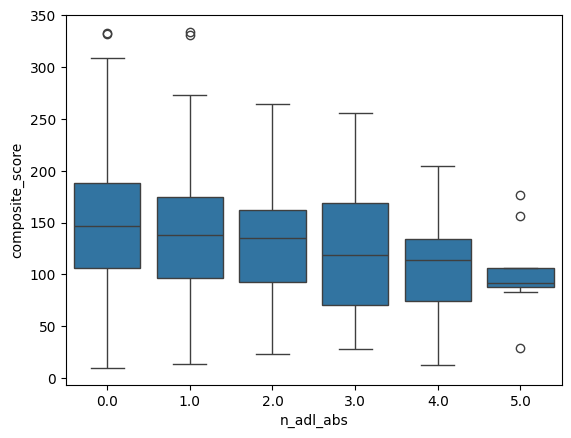

In [ ]:
combined_change_df['n_adl_abs'] = combined_change_df['n_adl'].abs()
sns.boxplot(data=combined_change_df, x='n_adl_abs', y='composite_score')

# Calculate the correlation between 'bmi_abs' and 'composite_score'
correlation = combined_change_df['n_adl_abs'].corr(combined_change_df['composite_score'])

# Print the correlation
print(f"The correlation between 'n_adl_abs' and 'composite_score' is: {correlation:.2f}")

<Axes: xlabel='mood_change', ylabel='composite_score'>

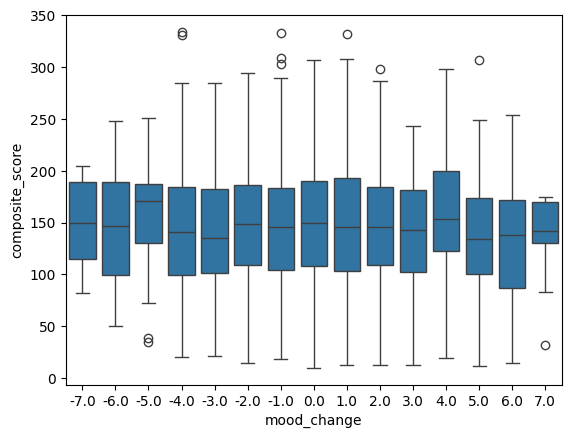

In [ ]:
sns.boxplot(data=combined_change_df, x='mood_change', y='composite_score')

The correlation between 'n_illnesses_abs' and 'composite_score' is: -0.05


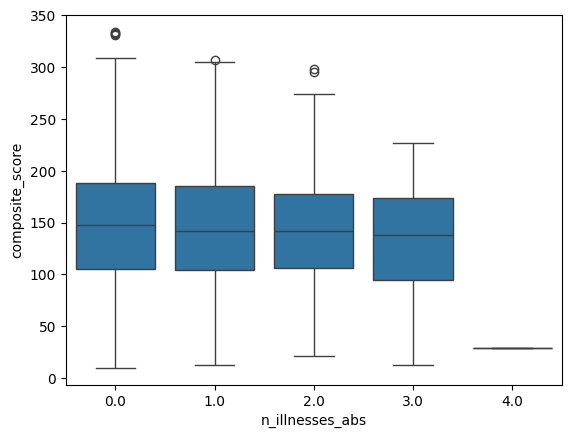

In [ ]:
combined_change_df['n_illnesses_abs'] = combined_change_df['n_illnesses'].abs()
sns.boxplot(data=combined_change_df, x='n_illnesses_abs', y='composite_score')

# Calculate the correlation between 'bmi_abs' and 'composite_score'
correlation = combined_change_df['n_illnesses_abs'].corr(combined_change_df['composite_score'])

# Print the correlation
print(f"The correlation between 'n_illnesses_abs' and 'composite_score' is: {correlation:.2f}")

The correlation between 'bmi_abs' and 'composite_score' is: -0.12


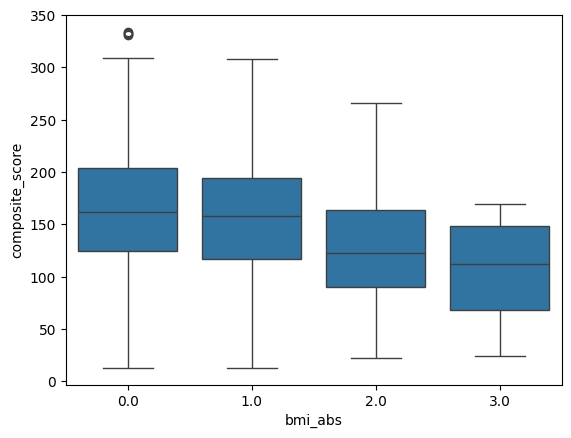

In [ ]:
# Create a new column 'bmi_squared' in the DataFrame
combined_change_df['bmi_abs'] = combined_change_df['bmi'].abs()

# Create the boxplot using 'bmi_squared' instead of 'bmi'
sns.boxplot(data=combined_change_df, x='bmi_abs', y='composite_score')

# Calculate the correlation between 'bmi_abs' and 'composite_score'
correlation = combined_change_df['bmi_abs'].corr(combined_change_df['composite_score'])

# Print the correlation
print(f"The correlation between 'bmi_abs' and 'composite_score' is: {correlation:.2f}")

#### Clustering ####

In [ ]:
# Load and preprocess your data
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index()

# Features and target
X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

# Split into train and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

# Apply data pipelines (assuming train_pipeline and test_pipeline are defined)
train_X, train_y = train_pipeline(X, y)

# Initialize the imputer with the strategy 'mean' (can also use 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in the data
train_X = pd.DataFrame(imputer.fit_transform(train_X), columns=train_X.columns)

# train_X = train_X[train_X['hincome'] != 36020000]
print(train_X.shape)

4343
(4343, 36)


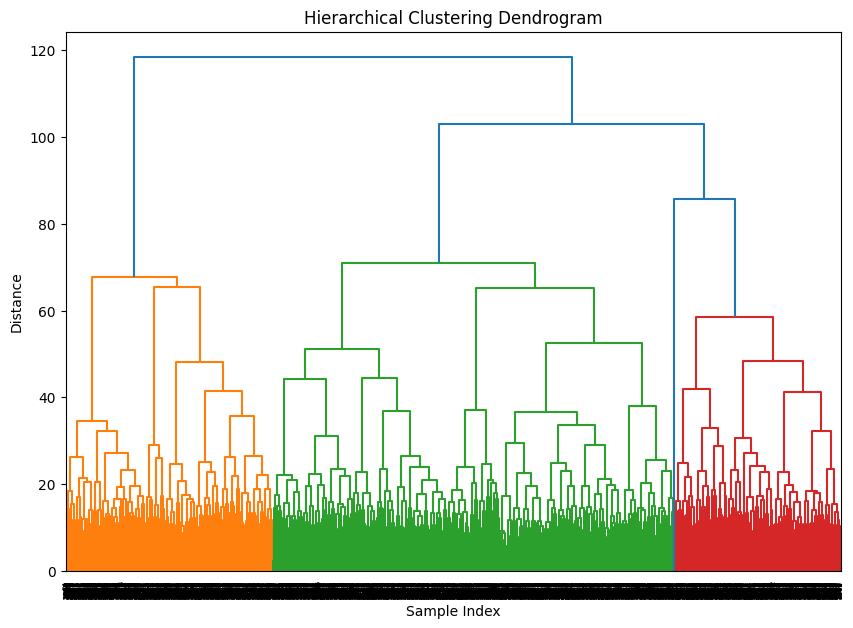

In [ ]:
# Step 1: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_X)

# Step 2: Perform hierarchical clustering
# Use the "ward" method for linkage
linkage_matrix = linkage(scaled_data, method='ward')

# Step 3: Visualize the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=train_X.index.tolist())
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()



In [ ]:
# Assuming linkage_matrix contains the results of hierarchical clustering
clusters = fcluster(linkage_matrix, t=4, criterion='maxclust')

# Add the cluster labels to the original data
train_X['cluster_auto'] = clusters

# Cut the dendrogram at a specific distance threshold to get four clusters
clusters = fcluster(linkage_matrix, t=70, criterion='distance')

# Add the cluster labels to the original data
train_X['cluster_height'] = clusters

train_X['composite_score'] = y
display(train_X)

,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_auto,cluster_height,composite_score
0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,...,9.0,0.0,2.0,0.0,0.0,0.0,2.9,2,3,175
1,1.0,1.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.9,3,4,206
2,0.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1.4,3,4,161
3,1.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,2.0,0.0,1.0,0.0,0.0,0.0,1.9,3,4,144
4,1.0,1.0,3.0,3.0,1.0,4.0,0.0,1.0,1.0,0.0,...,9.0,1.0,2.0,2.0,0.0,-1.0,2.9,1,1,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1.0,0.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,1.0,...,4.0,1.0,2.0,1.0,0.0,0.0,1.9,2,3,152
4339,0.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,9.0,1.0,2.0,2.0,0.0,0.0,2.4,2,3,140
4340,1.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,9.0,1.0,2.0,2.0,0.0,0.0,2.9,2,3,121
4341,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,1.0,...,9.0,0.0,2.0,1.0,0.0,0.0,2.9,2,3,32


In [ ]:
# Group by the cluster labels and calculate summary statistics
cluster_summary = train_X.groupby('cluster_height').describe()
print(cluster_summary)

cluster_means = train_X.groupby('cluster_height').mean()
print(cluster_means)
cluster_means.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/cluster_means.csv')

                  year                                                urban  \
                 count      mean       std  min  25%  50%  75%  max   count   
cluster_height                                                                
1               1164.0  0.609107  0.488160  0.0  0.0  1.0  1.0  1.0  1164.0   
2                978.0  0.639059  0.480519  0.0  0.0  1.0  1.0  1.0   978.0   
3               1269.0  0.658786  0.474304  0.0  0.0  1.0  1.0  1.0  1269.0   
4                931.0  0.618690  0.485970  0.0  0.0  1.0  1.0  1.0   931.0   
5                  1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0     1.0   

                          ... cluster_auto      composite_score              \
                    mean  ...          75%  max           count        mean   
cluster_height            ...                                                 
1               0.524914  ...          1.0  1.0          1164.0  138.536082   
2               0.736196  ...          2.0  2.0    

#### Basic Modelling ####

In [ ]:
# Linear Regression Model with Age and Education
joined_df_cleaned = joined_df.dropna(subset=['age_03', 'edu_gru_03'])
X = joined_df_cleaned[['age_03', 'edu_gru_03']]
y = joined_df_cleaned['composite_score']

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
model = LinearRegression()
model.fit(train_X, train_y)
val_predictions = model.predict(val_X)
val_mse = mean_squared_error(val_y, val_predictions)
val_r2 = r2_score(val_y, val_predictions)
val_rmse = np.sqrt(val_mse)
print(f"Validation MSE: {val_mse}")
print(f"Validation R^2: {val_r2}")
print(f"Validation RMSE: {val_rmse}")

Validation MSE: 1834.997477743085
Validation R^2: 0.47156991604744225
Validation RMSE: 42.83687054096138


### Modelling ###

#### Data Pipeline ####

In [ ]:
train_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_features.csv')
train_labels_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_labels.csv')
test_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/test_features.csv')

In [ ]:
# Convert categories to numerical numbers
def parse_class_num(value):
    try:
        match = re.search(r'\d+', str(value))
        if match:
            return int(match.group())
        else:
            return None
    except (ValueError, AttributeError):
        return None

def convert_categorical_to_numerical(df):
    columns_to_convert = ['age_03', 'age_12', 'urban_03', 'urban_12', 'married_03', 'married_12', 'edu_gru_03', 'edu_gru_12',\
                        'n_living_child_03', 'n_living_child_12', 'glob_hlth_03', 'glob_hlth_12', 'bmi_03', 'bmi_12', 'decis_famil_03', 'decis_famil_12',\
                        'decis_personal_03', 'decis_personal_12', 'employment_03', 'employment_12', 'memory_12', 'ragender', 'rrelgimp_03', 'rrelgimp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12',\
                        'satis_ideal_12', 'satis_excel_12', 'satis_fine_12', 'cosas_imp_12', 'wouldnt_change_12']

    columns_to_remove = ['rameduc_m', 'rafeduc_m', 'sgender_03', 'rjob_hrswk_03', 'rjlocc_m_03', 'rjob_end_03', 'rjobend_reason_03', 'rearnings_03', 'searnings_03', 'hinc_business_03',\
                        'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03', 'j11_12', 'a33b_12', 'a22_12', 'a16a_12',\
                        'sgender_12', 'rjob_hrswk_12', 'rjlocc_m_12', 'rjob_end_12', 'rjobend_reason_12', 'rearnings_12', 'searnings_12', 'hinc_business_12',\
                        'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12', 'a34_12']

    df = df.applymap(parse_class_num)
    return df

In [ ]:
# Calculate change variables between 2003 and 2012
def calc_change_vars(df):
    # For those with both 2003 and 2012, calculate change in variables
    both_years = ['n_adl', 'n_illnesses', 'bmi', 'exer_3xwk']

    both_years_03 = [var + '_03' for var in both_years]
    both_years_12 = [var + '_12' for var in both_years]

    # Filter the rows where both 2003 and 2012 values are non-null
    rows_with_both_ages = df[df['age_03'].notna() & df['age_12'].notna()]
    rows_with_both_ages = rows_with_both_ages[~rows_with_both_ages.index.duplicated(keep='first')]


    # Calculate the change in variables for those rows
    change_df = pd.DataFrame(index=rows_with_both_ages.index, columns=['uid'] + both_years)

    # Subtract 2012 values from 2003 values
    for var in both_years:
        change_df[var] = rows_with_both_ages[var + '_12'] - rows_with_both_ages[var + '_03']

    # Add the 'uid' column
    change_df['uid'] = rows_with_both_ages.index

    # # Display the resulting DataFrame
    # change_df.head()
    change_df = change_df.set_index('uid')

    change_df['n_adl_abs'] = change_df['n_adl'].abs()
    change_df['n_illnesses_abs'] = change_df['n_illnesses'].abs()
    change_df['bmi_abs'] = change_df['bmi'].abs()
    change_df['exer_3xwk_change'] = change_df['exer_3xwk']

    change_df = change_df.drop(columns=['n_adl', 'n_illnesses', 'bmi', 'exer_3xwk'])

    df = df.merge(change_df, left_index=True, right_index=True, how='left')

    return df

In [ ]:
# Parse out 2012 values if they exist, use the 2003 ones if 2012 don't exist
def parse_recent_values(df):
    only_2012 = ['memory_12', 'attends_class_12', 'attends_club_12', 'reads_12', 'games_12', 'table_games_12', 'comms_tel_comp_12', 'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'j11_12']
    both_years = ['age', 'urban', 'married', 'edu_gru', 'n_living_child', 'glob_hlth', 'adl_dress', 'adl_walk', 'adl_bath',\
                'adl_eat', 'adl_bed', 'adl_toilet', 'n_adl', 'iadl_money', 'iadl_meds', 'iadl_shop', 'iadl_meals',\
                'n_iadl', 'depressed', 'hard', 'restless', 'happy', 'lonely', 'enjoy', 'sad', 'tired', 'energetic', \
                'n_depr', 'cesd_depressed', 'hypertension', 'diabetes', 'resp_ill', 'arthritis', 'hrt_attack', 'stroke',\
                'cancer', 'n_illnesses', 'bmi', 'decis_famil', 'decis_personal', 'employment', 'hincome', 'rrelgimp']#, 'rjlocc_m', 'rjob_hrswk']


    # columns_to_remove = ['rameduc_m', 'rafeduc_m', 'sgender_03', 'rjob_hrswk_03', 'rjlocc_m_03', 'rjob_end_03', 'rjobend_reason_03', 'rearnings_03', 'searnings_03', 'hinc_business_03',\
    #                     'hinc_rent_03', 'hinc_assets_03', 'hinc_cap_03', 'rinc_pension_03', 'sinc_pension_03', 'j11_12', 'a33b_12', 'a22_12', 'a16a_12',\
    #                     'sgender_12', 'rjob_hrswk_12', 'rjlocc_m_12', 'rjob_end_12', 'rjobend_reason_12', 'rearnings_12', 'searnings_12', 'hinc_business_12',\
    #                     'hinc_rent_12', 'hinc_assets_12', 'hinc_cap_12', 'rinc_pension_12', 'sinc_pension_12', 'a34_12']

    gender = 'ragender'
    engineered_cols = ['n_adl_abs', 'n_illnesses_abs', 'bmi_abs', 'exer_3xwk_change']
    all_cols = ['years_passed', 'survey_year', 'year'] + both_years + [gender] + only_2012  + engineered_cols
    feature_df = pd.DataFrame(columns=all_cols)

    # if both_years + '_12' exist, use those values, if else, use the both_years + '_03', else use Nan
    for index, row in df.iterrows():
        survey_2012 = False
        new_row = []
        new_row.append(row['year'])
        # new_row.append(row['composite_score'])

        # for each variable that ends in 03 and 12
        for var in both_years:
            var_03 = var + '_03'
            var_12 = var + '_12'

            # if 12 exists, use that, if not use the 03 one
            if not np.isnan(row[var_12]):
                new_row.append(row[var_12])
                survey_2012 = True
            elif not np.isnan(row[var_03]):
                new_row.append(row[var_03])
            else:
                new_row.append(None)
        new_row.append(row[gender])

        # check each 2012 specific variables
        for var in only_2012:
            if not np.isnan(row[var]):
                new_row.append(row[var])
            else:
                new_row.append(None)

        # check for the newly engineered features
        for var in engineered_cols:
            if not np.isnan(row[var]):
                new_row.append(row[var])
            else:
                new_row.append(None)

        # if the 2012 survey exists, specify in dataframe
        if survey_2012:
            new_row.insert(0, 2012)
        else:
            new_row.insert(0, 2003)

        # Calculate number of years passed
        if new_row[0] == 2003 and new_row[1] == 2016:
            new_row.insert(0, 13)
        elif new_row[0] == 2003 and new_row[1] == 2021:
            new_row.insert(0, 18)
        elif new_row[0] == 2012 and new_row[1] == 2016:
            new_row.insert(0, 4)
        elif new_row[0] == 2012 and new_row[1] == 2021:
            new_row.insert(0, 9)
        else:
            print("NOTHING")

        feature_df.loc[index] = new_row

    return feature_df


In [ ]:
# Impute Nan values
# Compute and store imputation values
def compute_impute_values(df):
    # Specify columns for each strategy
    mean_columns = []#['hincome', 'n_adl_abs', 'n_illnesses_abs', 'exer_3xwk_change'] #hincome
    mode_columns = list(set(df.columns) - set(mean_columns))

    # Compute mean and mode
    mean_values = df[mean_columns].mean()
    mode_values = df[mode_columns].mode().iloc[0]

    return mean_values, mode_columns

# Apply stored imputation values
def apply_impute_values(df, mean_values, mode_columns, n_neighbors=3):
    # print(mean_values.index, mode_values.index)
    # print(mean_values, mode_values)
    # Impute mean
    df[mean_values.index] = df[mean_values.index].fillna(mean_values)

    # Initialize KNNImputer for mode imputation
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)

    # Impute mode columns using KNN
    df[mode_columns] = knn_imputer.fit_transform(df[mode_columns])
    return df

In [ ]:
# Create correlation matrix
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid').set_index('uid')
labels = train_df['composite_score']
train_df = train_df.drop(columns=['composite_score'])
train_df = train_pipeline(train_df, labels)
train_df = train_df[0]
display(train_df)

corr_matrix = train_df.corr()
corr_flat = corr_matrix.unstack().reset_index()
corr_flat.columns = ['Variable 1', 'Variable 2', 'Correlation']
high_corr = corr_flat[(corr_flat['Correlation'].abs() > 0) & (corr_flat['Variable 1'] != corr_flat['Variable 2'])]
high_corr = high_corr[(high_corr['Variable 1'] == 'composite_score') | (high_corr['Variable 2'] == 'composite_score')]
high_corr = high_corr.sort_values(by='Correlation', ascending=False)
high_corr = high_corr.drop_duplicates(subset=['Correlation'])
# high_corr.to_csv('/content/drive/MyDrive/PREPARE Challenge/Data/high_corr.csv')
# Display high correlations
print(high_corr)

NameError: name 'train_pipeline' is not defined

In [ ]:
# Drop outliers

# Calculate IQR and filter out outliers
def remove_outlier_group(df, group_col, value_col):
    # Compute Q1, Q3, and IQR for each group
    Q1 = df.groupby(group_col)[value_col].quantile(0.25)
    Q3 = df.groupby(group_col)[value_col].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate bounds
    bounds = pd.DataFrame({'lower_bound': Q1 - 1.5 * IQR, 'upper_bound': Q3 + 1.5 * IQR}).reset_index()

    # Merge bounds with original data
    df = df.merge(bounds, on=group_col)

    # Filter rows within bounds
    filtered_df = df[(df[value_col] >= df['lower_bound']) & (df[value_col] <= df['upper_bound'])]

    # Drop temporary columns
    return filtered_df.drop(['lower_bound', 'upper_bound'], axis=1)

def remove_outliers(df):
    df = remove_outlier_group(df, 'age', 'composite_score')
    df = remove_outlier_group(df, 'edu_gru', 'composite_score')

    return df


In [ ]:
# Add cumulative variables and scores:
def add_cumulative_variables(df):
    df['hincome_standardized'] = (df['hincome'] - df['hincome'].mean()) / df['hincome'].std()

    # Economic Stability Score
    df['economic_stability_score'] = (
        df['hincome_standardized'] +
        df['employment'] +
        df['urban'] +
        df['married']
    )

    # Education Quality Score
    df['education_quality_score'] = (
        df['edu_gru'] +
        df['reads_12'] +
        df['attends_class_12'] +
        df['games_12'] +
        df['table_games_12'] +
        df['j11_12']
    )

    # Healthcare Quality Score
    df['healthcare_quality_score'] = (
        df['glob_hlth'] +
        (df['n_illnesses'] + df['diabetes'] + df['arthritis'] + df['n_illnesses_abs']) +
        df['exer_3xwk_change']
    )

    # Neighborhood and Built Environment Score
    df['neighborhood_environment_score'] = (
        df['urban'] -
        (df['bmi'] + df['bmi_abs']) +
        df['n_living_child']
    )

    # Social and Community Context Score
    df['social_context_score'] = (
        (df['happy'] + df['enjoy'] + df['energetic'] + df['rsocact_m_12']) -
        (df['lonely'] + df['tired'] + df['restless'] + df['n_depr'] + df['rrfcntx_m_12'])
    )

    # Overall SDOH Score (optional)
    df['overall_sdo_score'] = (
        df['economic_stability_score'] +
        df['education_quality_score'] +
        df['healthcare_quality_score'] +
        df['neighborhood_environment_score'] +
        df['social_context_score']
    )

    df = df.drop(columns=['hincome_standardized'])
    return df


#### Pipeline with Mode imputation ####

In [ ]:
def train_pipeline(df, labels):
    df = convert_categorical_to_numerical(df)
    df = calc_change_vars(df)
    df = parse_recent_values(df)
    # mean_values, mode_values = compute_impute_values(df)
    # df = apply_impute_values(df, mean_values, mode_values)

    df['composite_score'] = labels
    df = df[(df['composite_score'] < 300) & (df['composite_score'] > 15)]

    df['year'] = df['year'].apply(lambda x: 1 if x == 2021 else 0)
    df['survey_year'] = df['survey_year'].apply(lambda x: 1 if x == 2012 else 0)
    df['new_age'] = df['age'] + (df['years_passed'] / 10)
    df = df[(df['hincome'] < 10000000) | df['hincome'].isna()]

    # df = add_cumulative_variables(df)
    df['age_x_illness'] = df['age'] * df['n_illnesses']

    df = df.drop(columns=['survey_year', 'new_age', 'depressed', 'cesd_depressed', 'iadl_shop', 'adl_bed', 'sad', 'adl_walk', 'adl_toilet', 'iadl_meals', 'comms_tel_comp_12',\
                          'iadl_meds', 'adl_eat', 'adl_bath', 'stroke', 'cancer', 'iadl_money', 'n_adl_abs', 'adl_dress', 'n_adl', 'resp_ill', 'hrt_attack', 'attends_club_12', 'years_passed',\
                          'hypertension']) #, 'ragender', 'enjoy'

    labels = df['composite_score']
    df = df.drop(columns=['composite_score'])

    return df, labels#, mean_values, mode_values

def test_pipeline(df):#, mean_values, mode_values):
    df = convert_categorical_to_numerical(df)
    df = calc_change_vars(df)
    df = parse_recent_values(df)
    # df = apply_impute_values(df, mean_values, mode_values)

    df['year'] = df['year'].apply(lambda x: 1 if x == 2021 else 0)
    df['survey_year'] = df['survey_year'].apply(lambda x: 1 if x == 2012 else 0)
    df['new_age'] = df['age'] + (df['years_passed'] / 10)

    # df = add_cumulative_variables(df)
    df['age_x_illness'] = df['age'] * df['n_illnesses']

    df = df.drop(columns=['survey_year', 'new_age', 'depressed', 'cesd_depressed', 'iadl_shop', 'adl_bed', 'sad', 'adl_walk', 'adl_toilet', 'iadl_meals', 'comms_tel_comp_12',\
                          'iadl_meds', 'adl_eat', 'adl_bath', 'stroke', 'cancer', 'iadl_money', 'n_adl_abs', 'adl_dress', 'n_adl', 'resp_ill', 'hrt_attack', 'attends_club_12', 'years_passed',\
                          'hypertension']) #, 'ragender', 'enjoy'

    return df

#### Linear Regression ####

In [ ]:
# Prepare data
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index()

X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

# Initialize k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    print(f"Fold {fold}")

    # Split the data into training and validation sets for this fold
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Preprocess the data
    train_X, train_y, mean_values, mode_values = train_pipeline(train_X, train_y)
    val_X = test_pipeline(val_X, mean_values, mode_values)

    # Standardize the features
    scaler = StandardScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled = scaler.transform(val_X)

    # Fit the model
    model = LinearRegression()
    model.fit(train_X_scaled, train_y)

    # Make predictions
    val_predictions = model.predict(val_X_scaled)
    val_mse = mean_squared_error(val_y, val_predictions)
    val_r2 = r2_score(val_y, val_predictions)
    val_rmse = np.sqrt(val_mse)

    # Print fold metrics
    # print(f"Validation MSE: {val_mse}")
    # print(f"Validation R²: {val_r2}")
    print(f"Validation RMSE: {val_rmse}")

    # Store metrics
    metrics.append((val_mse, val_r2, val_rmse))

# Calculate average metrics across folds
metrics = np.array(metrics)
avg_mse, avg_r2, avg_rmse = metrics.mean(axis=0)
std_mse, std_r2, std_rmse = metrics.std(axis=0)

print("\nCross-Validation Results:")
print(f"Average Validation MSE: {avg_mse:.4f} ± {std_mse:.4f}")
print(f"Average Validation R²: {avg_r2:.4f} ± {std_r2:.4f}")
print(f"Average Validation RMSE: {avg_rmse:.4f} ± {std_rmse:.4f}")


Fold 1
Validation RMSE: 40.00505373983581
Fold 2
Validation RMSE: 39.95766938251001
Fold 3
Validation RMSE: 41.34076091795234
Fold 4
Validation RMSE: 40.50773342939055
Fold 5
Validation RMSE: 42.750623351162545

Cross-Validation Results:
Average Validation MSE: 1674.9141 ± 86.3998
Average Validation R²: 0.5470 ± 0.0330
Average Validation RMSE: 40.9124 ± 1.0451


In [ ]:
# Residuals plot
plt.scatter(val_y, val_y - val_predictions)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


#### XGBoost ####

In [ ]:
# Perform Grid Search

# Load and preprocess your data
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index()

# Features and target
X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

# Apply data pipelines (assuming train_pipeline and test_pipeline are defined)
train_X, train_y = train_pipeline(X, y)

xgb = XGBRegressor(objective='reg:squarederror', random_state=8)

param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.03],
    'max_depth': [7],
    'subsample': [0.8],
    'colsample_bytree': [0.75],
    'min_child_weight': [50]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all processor
    return_train_score=True
)

grid_search.fit(train_X, train_y)

# Retrieve results
results = grid_search.cv_results_

# Print the training and validation RMSE for each parameter combination
print("Training and Validation RMSE:")
for i in range(len(results['params'])):
    params = results['params'][i]
    train_rmse = np.sqrt(-results['mean_train_score'][i])  # Convert to RMSE
    val_rmse = np.sqrt(-results['mean_test_score'][i])  # Convert to RMSE
    print(f"Params: {params}")
    print(f"  Training RMSE: {train_rmse}")
    print(f"  Validation RMSE: {val_rmse}")
    print("-" * 40)

# Get the best model
best_xgb = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Calculate and print the average RMSE from cross-validation
cv_results = grid_search.cv_results_
mean_rmse = np.mean(np.sqrt(-cv_results['mean_test_score']))  # Convert negative MSE to RMSE
print(f"Average RMSE from Cross-Validation: {mean_rmse}")

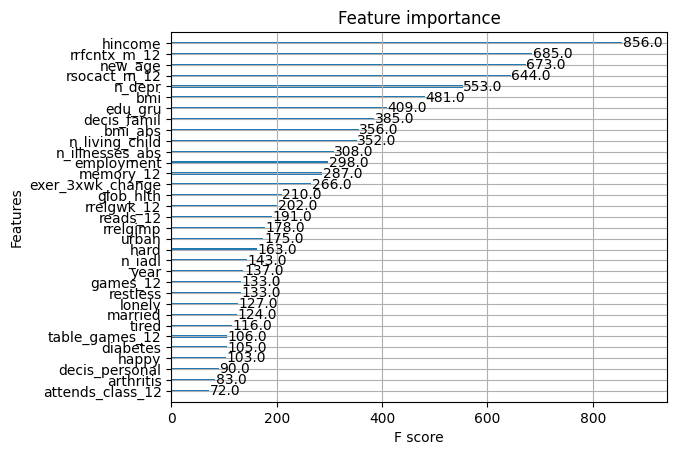

                  importance
edu_gru             0.366652
reads_12            0.071503
new_age             0.060448
games_12            0.037154
n_living_child      0.036210
n_iadl              0.023465
urban               0.022833
glob_hlth           0.022592
bmi                 0.020662
table_games_12      0.020249
rrfcntx_m_12        0.017568
hincome             0.017558
diabetes            0.017123
n_illnesses_abs     0.017075
bmi_abs             0.017014
rrelgimp            0.015916
rsocact_m_12        0.015868
decis_personal      0.015647
hard                0.013863
year                0.013694
employment          0.013079
arthritis           0.012767
n_depr              0.012685
married             0.012400
memory_12           0.012255
happy               0.012218
tired               0.011874
restless            0.011802
attends_class_12    0.011648
lonely              0.011598
decis_famil         0.011589
rrelgwk_12          0.011553
exer_3xwk_change    0.011440


In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(best_xgb)
plt.show()

#print features ordered by most important to least improtant
feature_importances = pd.DataFrame(best_xgb.feature_importances_, index=train_X.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#### CatBoost ####

In [ ]:
# Load and preprocess your data
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index()

# Features and target
X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

# Apply data pipelines (assuming train_pipeline and test_pipeline are defined)
train_X, train_y = train_pipeline(X, y)

print(train_X.shape[0])
print(train_X.shape[1])

# Specify categorical features
cat_features = list(train_X.columns)
cat_features.remove('hincome')

train_X[cat_features] = train_X[cat_features].fillna(-999).astype(int)

# Print types of each column
print(train_X.dtypes)

# Initialize CatBoostRegressor
catboost_model = CatBoostRegressor(random_state=8, silent=True)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.03],
    'iterations': [1000],
    'depth': [8],
    'l2_leaf_reg': [0.8],
    "task_type": ['GPU'],  # Enable GPU for CatBoost
    "devices": ['0'],
    "border_count": [32]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all processors
    return_train_score=True
)

display(train_X)

# Fit GridSearchCV
grid_search.fit(train_X, train_y, cat_features=cat_features)  # Specify categorical features

# Retrieve results
results = grid_search.cv_results_

# Print the training and validation RMSE for each parameter combination
print("Training and Validation RMSE:")
for i in range(len(results['params'])):
    params = results['params'][i]
    train_rmse = np.sqrt(-results['mean_train_score'][i])  # Convert to RMSE
    val_rmse = np.sqrt(-results['mean_test_score'][i])  # Convert to RMSE
    print(f"Params: {params}")
    print(f"  Training RMSE: {train_rmse}")
    print(f"  Validation RMSE: {val_rmse}")
    print("-" * 40)

# Get the best model
best_catboost = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Calculate and print the average RMSE from cross-validation
mean_rmse = np.mean(np.sqrt(-results['mean_test_score']))  # Convert negative MSE to RMSE
print(f"Average RMSE from Cross-Validation: {mean_rmse}")

4343
4301
39
year                  int64
age                   int64
urban                 int64
married               int64
edu_gru               int64
n_living_child        int64
glob_hlth             int64
n_iadl                int64
hard                  int64
restless              int64
happy                 int64
lonely                int64
enjoy                 int64
tired                 int64
energetic             int64
n_depr                int64
diabetes              int64
arthritis             int64
n_illnesses           int64
bmi                   int64
decis_famil           int64
decis_personal        int64
employment            int64
hincome             float64
rrelgimp              int64
ragender              int64
memory_12             int64
attends_class_12      int64
reads_12              int64
games_12              int64
table_games_12        int64
rrfcntx_m_12          int64
rsocact_m_12          int64
rrelgwk_12            int64
j11_12                int64
n_illne

,year,age,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,...,games_12,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,age_x_illness
0,1,2,0,1,0,1,4,0,0,0,...,0,0,9,9,0,2,-999,-999,-999,2
1,1,1,1,1,3,1,4,0,0,1,...,1,0,9,1,0,2,-999,-999,-999,1
2,0,1,0,1,1,3,4,0,0,1,...,0,0,6,2,0,1,-999,-999,-999,0
3,1,1,0,1,1,3,4,0,0,1,...,0,0,6,2,0,1,-999,-999,-999,0
4,1,2,1,3,3,1,4,0,1,1,...,0,0,4,9,1,2,2,0,-1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1,1,0,1,1,4,4,0,1,0,...,0,0,9,4,1,2,1,0,0,1
4339,0,2,0,3,1,1,3,0,1,1,...,0,0,9,9,1,2,2,-999,0,0
4340,1,2,0,3,1,1,3,0,1,1,...,0,0,9,9,1,2,2,-999,0,0
4341,1,2,0,1,0,2,3,0,0,0,...,-999,-999,-999,-999,-999,2,1,-999,-999,0


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training and Validation RMSE:
Params: {'border_count': 32, 'depth': 8, 'devices': '0', 'iterations': 1000, 'l2_leaf_reg': 0.8, 'learning_rate': 0.03, 'task_type': 'GPU'}
  Training RMSE: 34.70573206314966
  Validation RMSE: 39.79530731004877
----------------------------------------
Best Parameters: {'border_count': 32, 'depth': 8, 'devices': '0', 'iterations': 1000, 'l2_leaf_reg': 0.8, 'learning_rate': 0.03, 'task_type': 'GPU'}
Average RMSE from Cross-Validation: 39.79530731004877


#### Multi-Level Regression ####

In [ ]:
# Load and preprocess your data
print(train_labels_orig.shape[0])
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index()

# Features and target
X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

# Apply data pipelines (assuming train_pipeline and test_pipeline are defined)
train_X, train_y = train_pipeline(X, y)

# Initialize the imputer with the strategy 'mean' (can also use 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values in the data
train_X = pd.DataFrame(imputer.fit_transform(train_X), columns=train_X.columns)

# Step 1: Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_X)

# Step 2: Perform hierarchical clustering
# Use the "ward" method for linkage
linkage_matrix = linkage(scaled_data, method='ward')

# Cut the dendrogram at a specific distance threshold to get four clusters
clusters = fcluster(linkage_matrix, t=70, criterion='distance')

# Add the cluster labels to the original data
train_X['cluster_height'] = clusters

train_df = train_X.join(train_y)

train_df = train_df[train_df['cluster_height'] != 5]
train_df = train_df[(train_df['composite_score'] < 300) & (train_df['composite_score'] > 15)]

print(train_df.shape)
cluster_summary = train_df.groupby('cluster_height').describe()
print(train_df.columns)

4343
(4301, 38)
Index(['year', 'urban', 'married', 'edu_gru', 'n_living_child', 'glob_hlth',
       'n_iadl', 'hard', 'restless', 'happy', 'lonely', 'tired', 'energetic',
       'n_depr', 'diabetes', 'arthritis', 'n_illnesses', 'bmi', 'decis_famil',
       'decis_personal', 'employment', 'hincome', 'rrelgimp', 'memory_12',
       'attends_class_12', 'reads_12', 'games_12', 'table_games_12',
       'rrfcntx_m_12', 'rsocact_m_12', 'rrelgwk_12', 'j11_12',
       'n_illnesses_abs', 'bmi_abs', 'exer_3xwk_change', 'new_age',
       'cluster_height', 'composite_score'],
      dtype='object')


In [ ]:
# Add RMSE function
def compute_rmse(true_values, predictions):
    return np.sqrt(np.mean((true_values - predictions) ** 2))

# Get the list of columns excluding 'composite_score' and 'cluster_height'
feature_columns = [col for col in train_df.columns if col not in ['composite_score', 'cluster_height']]

# Construct the formula dynamically
formula = "composite_score ~ " + " + ".join(feature_columns)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for train_index, test_index in kf.split(train_df):
    train_data, test_data = train_df.iloc[train_index], train_df.iloc[test_index]

    # Fit model on training data
    model_cv = smf.mixedlm(
        formula,
        data=train_data,
        groups=train_data["cluster_height"],
        re_formula="~1"
    )
    result_cv = model_cv.fit()

    # Predict on test data
    test_data["predictions"] = result_cv.predict(test_data)

    # Compute RMSE for this fold
    rmse = compute_rmse(test_data["composite_score"], test_data["predictions"])
    rmse_scores.append(rmse)

# Average RMSE across folds
print(f"Cross-Validation RMSE: {np.mean(rmse_scores)}")


Cross-Validation RMSE: 40.22752865920374


#### Aggregated Models ####

In [ ]:
train_df = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_df = train_df.reset_index(drop=True)

# Features and target
X = train_df.drop(columns=['composite_score'])
y = train_df['composite_score']

X, y = train_pipeline(X, y)

cat_features = list(train_X.columns)
cat_features.remove('hincome')
# cat_features.remove('new_age')


X[cat_features] = X[cat_features].fillna(-999).astype(int)


In [ ]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []
optimized_weights_list = []

for train_index, val_index in tqdm(kf.split(X)):
    # Split the data
    train_X, val_X = X.iloc[train_index], X.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train LightGBM
    train_data = lgb.Dataset(train_X, label=train_y, categorical_feature='auto')
    val_data = lgb.Dataset(val_X, label=val_y, categorical_feature='auto')

    # Define parameters
    params = {
        'objective': 'regression',  # default for regression
        'metric': 'rmse',
        'learning_rate': 0.01,
        'n_estimators': 10000,
        'random_seed': 42
    }

    # Train the model with early stopping
    model1 = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=500, verbose=True),
        ]
    )
    pred1 = model1.predict(val_X, num_iteration=model1.best_iteration)

    # Train CatBoost
    model2 = CatBoostRegressor(
        iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
        cat_features=cat_features,
        verbose=100, early_stopping_rounds=500, task_type='GPU', devices='0')
    model2.fit(train_X, train_y, eval_set=(val_X, val_y))
    pred2 = model2.predict(val_X)

    # Train XGBoost
    model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42,
        enable_categorical=True,
        eval_metric=root_mean_squared_error,
        early_stopping_rounds=500)
    model3.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred3 = model3.predict(val_X)

    # Define loss function for weight optimization
    def loss_function(weights):
        w1, w2, w3 = weights
        combined_predictions = w1 * pred1 + w2 * pred2 + w3 * pred3
        mse = np.mean((combined_predictions - val_y) ** 2)
        return mse

    # Initial weights
    initial_weights = [1/3, 1/3, 1/3]

    # Constraints: weights must sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] - 1}

    # Bounds: weights must be between 0 and 1
    bounds = [(0, 1), (0, 1), (0, 1)]

    # Optimize weights
    result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)
    optimized_weights = result.x

    # Combine predictions using optimized weights
    final_predictions = (
        optimized_weights[0] * pred1 +
        optimized_weights[1] * pred2 +
        optimized_weights[2] * pred3)

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions)  # RMSE
    fold_results.append(fold_mse)
    optimized_weights_list.append(optimized_weights)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")
print(f"Optimized weights per fold: {optimized_weights_list}")


### Inference Code ###

#### Aggregation Models ####

In [ ]:
submission_df = submission_df_orig.copy()
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')

test_features = test_pipeline(test_features)

In [ ]:
# Calculate the average weights from cross-validation
average_weights = np.mean(optimized_weights_list, axis=0)

# Train models on the entire training dataset
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')

params = {
    'objective': 'regression',  # default for regression
    'metric': 'rmse',
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'random_seed': 42
}
final_model1 = lgb.train(
    params,
    train_data
)

final_model3 = XGBRegressor(n_estimators=10000, learning_rate=0.01,
        max_depth=3, random_state=42,
        enable_categorical=True,
        eval_metric=root_mean_squared_error)
final_model3.fit(X, y)

final_model2 = CatBoostRegressor(
    iterations=10000, learning_rate=0.01, depth=10, loss_function='RMSE',
    cat_features=cat_features,
    verbose=100, task_type='GPU', devices='0'
)
final_model2.fit(X, y)

# Generate predictions on the test dataset
test_pred1 = final_model1.predict(test_features)
test_pred2 = final_model2.predict(test_features)
test_pred3 = final_model3.predict(test_features)

# Combine the predictions using the average weights
final_test_predictions = (
    average_weights[0] * test_pred1 + average_weights[1] * test_pred2 + average_weights[2] * test_pred3
)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(final_test_predictions).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

submission_df['composite_score']=final_test_predictions
#generate submission
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/final.csv')

#### Linear Regression ####

In [ ]:
submission_df_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/submission_format.csv')
test_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/test_features.csv')
train_features_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_features.csv')
train_labels_orig = pd.read_csv('/content/drive/MyDrive/PREPARE Challenge/Data/train_labels.csv')

In [ ]:
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')
train_features = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_labels = train_features['composite_score']
train_features = train_features.drop(columns=['composite_score'])

train_features, train_labels, mean_values, mode_values = train_pipeline(train_features, train_labels)
test_features = test_pipeline(test_features, mean_values, mode_values)

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

print(train_features_scaled.shape)
print(test_features_scaled.shape)

model = LinearRegression()
model.fit(train_features_scaled, train_labels)

predictions = model.predict(test_features_scaled)

submission_df['composite_score'] = predictions
submission_df = submission_df.set_index('uid')
submission_df['composite_score'] = submission_df['composite_score'].round(0).astype(int)
submission_df['year'] = submission_df['year'].astype(int)
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/submission_regression_3.csv')

#### XGBoost ####

In [ ]:
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')
train_features = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_labels = train_features['composite_score']
train_features = train_features.drop(columns=['composite_score'])

train_features, train_labels = train_pipeline(train_features, train_labels)
test_features = test_pipeline(test_features)

params = {
    'n_estimators': 300,
    'learning_rate': 0.03,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 1.0,
    'min_child_weight': 10,
    'objective': 'reg:squarederror',
    'random_state': 8
}

print(train_features.shape[0])

best_xgb = XGBRegressor(**params)
best_xgb.fit(train_features, train_labels)

predictions = best_xgb.predict(test_features)

submission_df['composite_score'] = predictions
submission_df = submission_df.set_index('uid')
submission_df['composite_score'] = submission_df['composite_score'].round(0).astype(int)
submission_df['year'] = submission_df['year'].astype(int)
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/submission_xgboost_5.csv')

4302


#### CATBoost ####

In [ ]:
submission_df = submission_df_orig.copy()
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')
train_features = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_labels = train_features['composite_score']
train_features = train_features.drop(columns=['composite_score'])

train_features, train_labels = train_pipeline(train_features, train_labels)
test_features = test_pipeline(test_features)


params = {
    'learning_rate': 0.03,
    'iterations': 1000,
    'depth': 8,
    'l2_leaf_reg': 1,
    "task_type": 'GPU',  # Enable GPU for CatBoost
    "devices": '0',
    "border_count": 32
}

# Specify categorical features
cat_features = list(train_features.columns)
cat_features.remove('hincome')


train_features[cat_features] = train_features[cat_features].fillna(-999).astype(int)
test_features[cat_features] = test_features[cat_features].fillna(-999).astype(int)

print(train_features.shape[0])

best_cat = CatBoostRegressor(**params, silent=True)
best_cat.fit(train_features, train_labels, cat_features=cat_features)

predictions = best_cat.predict(test_features)

submission_df['composite_score'] = predictions
submission_df = submission_df.set_index('uid')
submission_df['composite_score'] = submission_df['composite_score'].round(0).astype(int)
submission_df['year'] = submission_df['year'].astype(int)
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/submission_catboost_11.csv')

4301


#### CATBoost with clustering ####

In [ ]:
def cluster_data(train_X):
    # Initialize the imputer with the strategy 'mean' (can also use 'median' or 'most_frequent')
    imputer = SimpleImputer(strategy='most_frequent')

    # Impute missing values in the data
    train_X = pd.DataFrame(imputer.fit_transform(train_X), columns=train_X.columns)

    # # Step 1: Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(train_X)

    # Step 2: Perform hierarchical clustering
    # Use the "ward" method for linkage
    linkage_matrix = linkage(scaled_data, method='ward')

    # Cut the dendrogram at a specific distance threshold to get four clusters
    clusters = fcluster(linkage_matrix, t=70, criterion='distance')

    return clusters, scaler, imputer



In [ ]:
def assign_new_points_to_clusters_hierarchical(train_data, new_points, scaler, imputer):
    """
    Assigns new points to clusters created with hierarchical clustering.

    Parameters:
        train_data (DataFrame or ndarray): The scaled training data used for clustering.
        train_clusters (array-like): Cluster labels for the training data.
        new_points (DataFrame or ndarray): The unscaled new points to assign to clusters.
        scaler (scaler object): A fitted scaler used for preprocessing the training data.

    Returns:
        DataFrame: New points with an added 'cluster_height' column indicating assigned clusters.
    """
    # Validate inputs
    train_clusters = train_data['cluster_height']
    train_data = train_data.drop(columns=['cluster_height'])

    new_points_orig = new_points.copy()

    train_data = pd.DataFrame(imputer.transform(train_data), columns=train_data.columns)
    new_points = pd.DataFrame(imputer.transform(new_points), columns=new_points.columns)

    train_data = scaler.transform(train_data)
    new_points = scaler.transform(new_points)

    train_clusters = train_clusters.to_numpy() # Ensure train_clusters is a numpy array

    # Compute distances from new points to all training data points
    distances = cdist(new_points, train_data, metric='euclidean')

    # Find the closest training data point for each new point
    closest_points = np.argmin(distances, axis=1)

    # Assign clusters based on the closest training point
    new_clusters = train_clusters[closest_points]

    # Add the cluster assignments to the new points DataFrame or ndarray
    if isinstance(new_points_orig, np.ndarray):
        new_points_with_clusters = np.column_stack((new_points_orig, new_clusters))
    else:
        new_points_orig['cluster_height'] = new_clusters
        new_points_with_clusters = new_points_orig

    return new_points_with_clusters


In [ ]:
submission_df = submission_df_orig.copy()
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')
train_features = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_labels = train_features['composite_score']
train_features = train_features.drop(columns=['composite_score'])

train_features, train_labels = train_pipeline(train_features, train_labels)
test_features = test_pipeline(test_features)

clusters, scaler, imputer = cluster_data(train_features)
train_features['cluster_height'] = clusters
cluster_summary = train_features.groupby('cluster_height').describe()

train_df = train_features.join(train_labels)
train_df = train_df[train_df['cluster_height'] != 5]
train_df = train_df[(train_df['composite_score'] < 300) & (train_df['composite_score'] > 15)]
train_features = train_df.drop(columns=['composite_score'])
train_labels = train_df['composite_score']

test_features = assign_new_points_to_clusters_hierarchical(train_features, test_features, scaler, imputer)
cluster_summary = test_features.groupby('cluster_height').describe()

# Define the parameter grid
params = {
    'learning_rate': 0.03,
    'iterations': 1000,
    'depth': 8,
    'l2_leaf_reg': 1,
    # "task_type": 'GPU',  # Enable GPU for CatBoost
    # "devices": '0',
    "border_count": 32
}

# Specify categorical features
cat_features = list(train_features.columns)
cat_features.remove('hincome')
cat_features.remove('new_age')


train_features[cat_features] = train_features[cat_features].fillna(-999).astype(int)
test_features[cat_features] = test_features[cat_features].fillna(-999).astype(int)

best_cat = CatBoostRegressor(**params, silent=True)
best_cat.fit(train_features, train_labels, cat_features=cat_features)

predictions = best_cat.predict(test_features)

submission_df['composite_score'] = predictions
submission_df = submission_df.set_index('uid')
submission_df['composite_score'] = submission_df['composite_score'].round(0).astype(int)
submission_df['year'] = submission_df['year'].astype(int)
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/submission_catboost_5.csv')

,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,1,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,2.0,NaN,NaN,NaN,2.9,3
1,1,1.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,1.0,...,0.0,9.0,1.0,0.0,2.0,NaN,NaN,NaN,1.9,4
2,0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,NaN,NaN,NaN,1.4,4
3,1,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,NaN,NaN,NaN,1.9,4
4,1,1.0,3.0,3.0,1.0,4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,9.0,1.0,2.0,2.0,0.0,-1.0,2.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1,0.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,1.0,...,0.0,9.0,4.0,1.0,2.0,1.0,0.0,0.0,1.9,3
4339,0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,NaN,0.0,2.4,3
4340,1,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,NaN,0.0,2.9,3
4341,1,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,2.9,3


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,games_12,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age
0,0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.4
1,0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.4
2,1,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.9
3,0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,1.0,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.4
4,1,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,1.0,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.4
1101,1,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.9
1102,0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4
1103,1,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9


4301
4301
[ 353 3441 2120 ... 2036 1814 3959]
ELSE


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.4,2
1,0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.4,3
2,1,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.9,2
3,0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.4,2
4,1,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.4,3
1101,1,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.9,3
1102,0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4,2
1103,1,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9,2


                 year                                               urban  \
                count      mean       std  min  25%  50%  75%  max  count   
cluster_height                                                              
1               275.0  0.610909  0.488433  0.0  0.0  1.0  1.0  1.0  275.0   
2               249.0  0.634538  0.482529  0.0  0.0  1.0  1.0  1.0  249.0   
3               370.0  0.643243  0.479691  0.0  0.0  1.0  1.0  1.0  370.0   
4               211.0  0.639810  0.481197  0.0  0.0  1.0  1.0  1.0  211.0   

                          ... exer_3xwk_change      new_age            \
                    mean  ...              75%  max   count      mean   
cluster_height            ...                                           
1               0.530909  ...              0.0  1.0   275.0  2.890909   
2               0.819277  ...              0.0  1.0   249.0  2.633735   
3               0.316216  ...              0.0  1.0   369.0  2.839566   
4               0.7772

,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,1,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,2.0,NaN,NaN,NaN,2.9,3
1,1,1.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,1.0,...,0.0,9.0,1.0,0.0,2.0,NaN,NaN,NaN,1.9,4
2,0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,NaN,NaN,NaN,1.4,4
3,1,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,NaN,NaN,NaN,1.9,4
4,1,1.0,3.0,3.0,1.0,4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,9.0,1.0,2.0,2.0,0.0,-1.0,2.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1,0.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,1.0,...,0.0,9.0,4.0,1.0,2.0,1.0,0.0,0.0,1.9,3
4339,0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,NaN,0.0,2.4,3
4340,1,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,NaN,0.0,2.9,3
4341,1,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,2.9,3


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.4,2
1,0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.4,3
2,1,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,NaN,NaN,NaN,1.9,2
3,0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.4,2
4,1,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,NaN,NaN,NaN,2.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.4,3
1101,1,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,NaN,NaN,NaN,1.9,3
1102,0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4,2
1103,1,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9,2


4301


#### Multi Level Regression

In [ ]:
submission_df = submission_df_orig.copy()
test_features = submission_df.join(test_features_orig.set_index('uid'), on='uid')
train_features = train_labels_orig.join(train_features_orig.set_index('uid'), on='uid')
train_labels = train_features['composite_score']
train_features = train_features.drop(columns=['composite_score'])

train_features, train_labels = train_pipeline(train_features, train_labels)
test_features = test_pipeline(test_features)

clusters, scaler, imputer = cluster_data(train_features)
train_features = pd.DataFrame(imputer.transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(imputer.transform(test_features), columns=test_features.columns)
train_features['cluster_height'] = clusters
cluster_summary = train_features.groupby('cluster_height').describe()

train_df = train_features.join(train_labels)
train_df = train_df[train_df['cluster_height'] != 5]
train_df = train_df[(train_df['composite_score'] < 300) & (train_df['composite_score'] > 15)]
train_features = train_df.drop(columns=['composite_score'])
train_labels = train_df['composite_score']

test_features = assign_new_points_to_clusters_hierarchical(train_features, test_features, scaler, imputer)
cluster_summary = test_features.groupby('cluster_height').describe()


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,2.0,0.0,0.0,0.0,2.9,3
1,1.0,1.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,1.0,...,0.0,9.0,1.0,0.0,2.0,0.0,0.0,0.0,1.9,4
2,0.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,1.4,4
3,1.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,0.0,6.0,2.0,0.0,1.0,0.0,0.0,0.0,1.9,4
4,1.0,1.0,3.0,3.0,1.0,4.0,0.0,1.0,1.0,0.0,...,0.0,4.0,9.0,1.0,2.0,2.0,0.0,-1.0,2.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1.0,0.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,1.0,...,0.0,9.0,4.0,1.0,2.0,1.0,0.0,0.0,1.9,3
4339,0.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,0.0,0.0,2.4,3
4340,1.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,0.0,9.0,9.0,1.0,2.0,2.0,0.0,0.0,2.9,3
4341,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,2.0,1.0,0.0,0.0,2.9,3


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,games_12,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age
0,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4
1,0.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.4
2,1.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.9
3,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,1.0,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.4
4,1.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,1.0,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4
1101,1.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.9
1102,0.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4
1103,1.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9


4301
4301
[ 353 3441 2120 ... 2036 1814 3959]
ELSE


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4,2
1,0.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.4,3
2,1.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.9,2
3,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.4,2
4,1.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4,3
1101,1.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.9,3
1102,0.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4,2
1103,1.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9,2


                 year                                               urban  \
                count      mean       std  min  25%  50%  75%  max  count   
cluster_height                                                              
1               275.0  0.610909  0.488433  0.0  0.0  1.0  1.0  1.0  275.0   
2               249.0  0.634538  0.482529  0.0  0.0  1.0  1.0  1.0  249.0   
3               370.0  0.643243  0.479691  0.0  0.0  1.0  1.0  1.0  370.0   
4               211.0  0.639810  0.481197  0.0  0.0  1.0  1.0  1.0  211.0   

                          ... exer_3xwk_change      new_age            \
                    mean  ...              75%  max   count      mean   
cluster_height            ...                                           
1               0.530909  ...              0.0  1.0   275.0  2.890909   
2               0.819277  ...              0.0  1.0   249.0  2.633735   
3               0.316216  ...              0.0  1.0   370.0  2.839730   
4               0.7772

,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height,composite_score
0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,1.0,...,9.0,9.0,0.0,2.0,0.0,0.0,0.0,2.9,3,175
1,1.0,1.0,1.0,3.0,1.0,4.0,0.0,0.0,1.0,1.0,...,9.0,1.0,0.0,2.0,0.0,0.0,0.0,1.9,4,206
2,0.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,6.0,2.0,0.0,1.0,0.0,0.0,0.0,1.4,4,161
3,1.0,0.0,1.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,...,6.0,2.0,0.0,1.0,0.0,0.0,0.0,1.9,4,144
4,1.0,1.0,3.0,3.0,1.0,4.0,0.0,1.0,1.0,0.0,...,4.0,9.0,1.0,2.0,2.0,0.0,-1.0,2.9,1,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,1.0,0.0,1.0,1.0,4.0,4.0,0.0,1.0,0.0,1.0,...,9.0,4.0,1.0,2.0,1.0,0.0,0.0,1.9,3,152
4339,0.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,9.0,9.0,1.0,2.0,2.0,0.0,0.0,2.4,3,140
4340,1.0,0.0,3.0,1.0,1.0,3.0,0.0,1.0,1.0,1.0,...,9.0,9.0,1.0,2.0,2.0,0.0,0.0,2.9,3,121
4341,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,1.0,...,9.0,9.0,0.0,2.0,1.0,0.0,0.0,2.9,3,32


,year,urban,married,edu_gru,n_living_child,glob_hlth,n_iadl,hard,restless,happy,...,table_games_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,j11_12,n_illnesses_abs,bmi_abs,exer_3xwk_change,new_age,cluster_height
0,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4,2
1,0.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.4,3
2,1.0,1.0,2.0,4.0,1.0,2.0,0.0,0.0,0.0,0.0,...,0.0,9.0,9.0,1.0,2.0,0.0,0.0,0.0,1.9,2
3,0.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.4,2
4,1.0,1.0,1.0,2.0,2.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,1.0,1.0,0.0,0.0,0.0,2.9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.4,3
1101,1.0,1.0,3.0,1.0,2.0,3.0,0.0,0.0,0.0,1.0,...,0.0,4.0,9.0,0.0,1.0,0.0,0.0,0.0,1.9,3
1102,0.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.4,2
1103,1.0,1.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,1.0,...,0.0,9.0,3.0,0.0,1.0,1.0,1.0,-1.0,2.9,2


In [ ]:
# Get the list of columns excluding 'composite_score' and 'cluster_height'
feature_columns = [col for col in train_df.columns if col not in ['composite_score', 'cluster_height']]
formula = "composite_score ~ " + " + ".join(feature_columns)

# Fit model on training data
model_cv = smf.mixedlm(
    formula,
    data=train_df,
    groups=train_df["cluster_height"],
    re_formula="~1"
)
result_cv = model_cv.fit()

# Predict on test data
predictions = result_cv.predict(test_features)

submission_df['composite_score'] = predictions
submission_df = submission_df.set_index('uid')
submission_df['composite_score'] = submission_df['composite_score'].round(0).astype(int)
submission_df['year'] = submission_df['year'].astype(int)
submission_df.to_csv('/content/drive/MyDrive/PREPARE Challenge/Submissions/submission_mlregression_5.csv')